# Fit DSPS SED models with Fors2 Spectra with JAXOPT and Photometry


- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- CC: kernel conda_jax0235_py310
- creation date : 2023-11-13
- update : 2023-11-14 : add interpax interpolation and fitted sfr, and filter object and pytree


| computer | processor | kernel              |    date     |
| --- | --- | --- | --- |
| CC       | CPU       | conda_jax0325_py310 | 2023-11-10  |
| macbookpro | CPU | conda_jaxcpu_dsps_py310 | 2023-11-10  | 


libraries 
=========

jax
---

- jaxlib-0.3.25+cuda11.cudnn82
- jaxopt
- optax
- corner
- arviz
- numpyro
- interpax

sps
---

- fsps
- prospect
- dsps
- diffstar
- diffmah
- sedpy or astro-sedpy

plot
----

- matplotlib
- seaborn

(conda_jax0325_py310) 
`/pbs/throng/lsst/users/dagoret/desc/StellarPopulationSynthesis>pip list | grep` 

| lib | version |
|--- | --- | 
|jax  |                         0.4.20 |
|jaxlib |                       0.4.20 |
|jaxopt  |                      0.8.2 |



https://github.com/sylvielsstfr/Fors2ToStellarPopSynthesis/blob/main/examples/examples_jaxtutos/jaxtuto_jec2022/JAX-Optim-regression-piecewise.ipynb

In [1]:
import jax
import jax.numpy as jnp
jax.devices()

[CpuDevice(id=0)]

In [2]:
from sedpy import observate

In [3]:

import numpy as np
import scipy as sc

import jax
import jax.numpy as jnp
import jax.scipy as jsc

from jax import grad, jit, vmap
from jax import jacfwd, jacrev, hessian

import jaxopt
import optax

jax.config.update("jax_enable_x64", True)
import corner
import arviz as az

import copy
from interpax import interp1d

In [4]:
import itertools

In [5]:
import h5py
import pandas as pd
import numpy as np
import os
from astropy.io import fits
from astropy.table import Table
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.cm as cmx
from collections import OrderedDict
import re
import matplotlib.gridspec as gridspec
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

In [6]:
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [7]:
from diffstar.defaults import DEFAULT_MAH_PARAMS
from diffstar.defaults import DEFAULT_MS_PARAMS
from diffstar.defaults import DEFAULT_Q_PARAMS

In [8]:
from diffstar import sfh_singlegal
from dsps.cosmology import age_at_z, DEFAULT_COSMOLOGY

In [9]:
from dsps import load_ssp_templates

In [10]:
from dsps import calc_rest_sed_sfh_table_lognormal_mdf
from dsps import calc_rest_sed_sfh_table_met_table

In [11]:
from dsps import calc_rest_mag, calc_obs_mag

In [12]:
from dsps.dust.att_curves import  sbl18_k_lambda, RV_C00,_frac_transmission_from_k_lambda

### Very important add the lib to load the data

In [13]:
import sys
sys.path.append("../../lib")

In [14]:
from fit_params_fors2 import U_FNU,U_FL,ConvertFlambda_to_Fnu,flux_norm,ordered_keys,Fors2DataAcess

In [15]:
lambda_red = 6231
lambda_width = 50
lambda_sel_min = lambda_red-lambda_width /2.
lambda_sel_max = lambda_red+lambda_width /2.

# Filters

### Build Tables for filters

In [16]:
class FilterInfo():
    def __init__(self):
        self.filters_galex = np.array(["galex_FUV","galex_NUV"])
        self.filters_sdss = np.array(["sdss_u0","sdss_g0","sdss_r0","sdss_i0"])
        self.filters_vircam = np.array(["vista_vircam_Z","vista_vircam_Y","vista_vircam_J","vista_vircam_H","vista_vircam_Ks"])

        # Galex filters
        self.all_filt_galex = []
        for filtname in self.filters_galex:
            filt = observate.Filter(filtname)
            self.all_filt_galex.append(filt)   
        self.N_galex = len(self.all_filt_galex)
        # colors for Galex
        cmap = mpl.cm.PuBu
        cNorm = colors.Normalize(vmin=0, vmax=self.N_galex)
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
        self.all_colors_galex = scalarMap.to_rgba(np.arange(self.N_galex+1), alpha=1)

        # SDSS filters (for KIDS survey)
        self.all_filt_sdss = []
        for filtname in self.filters_sdss:
            filt = observate.Filter(filtname)
            self.all_filt_sdss.append(filt)  
        self.N_sdss = len(self.all_filt_sdss)
        # colors for SDSS
        cmap = mpl.cm.Reds
        cNorm = colors.Normalize(vmin=0, vmax=self.N_sdss)
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
        self.all_colors_sdss = scalarMap.to_rgba(np.arange(self.N_sdss+1), alpha=1)

        # VIRCAM
        self.all_filt_vircam = []
        for filtname in self.filters_vircam:
            filt = observate.Filter(filtname)
            self.all_filt_vircam.append(filt) 
        self.N_vircam = len(self.all_filt_vircam)
        # colors for Vircam
        cmap = mpl.cm.Wistia
        cNorm = colors.Normalize(vmin=0, vmax=self.N_vircam)
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
        self.all_colors_vircam = scalarMap.to_rgba(np.arange(self.N_vircam+1), alpha=1)
        


        self.filters_indexlist = []
        self.filters_surveylist = []
        self.filters_namelist = []
        self.filters_transmissionlist = []
        self.filters_transmissionnormlist = []
        self.filters_colorlist = []
        
        filter_count = 0
        
        for index in range(self.N_galex):
            self.filters_indexlist.append(filter_count)
            self.filters_surveylist.append("galex") 
            self.filters_namelist.append(self.filters_galex[index])
            self.filters_transmissionlist.append(self.all_filt_galex[index])
            self.filters_transmissionnormlist.append(100.0)
            self.filters_colorlist.append(self.all_colors_galex[index+1])
            filter_count+= 1
            
        for index in range(self.N_sdss):
            self.filters_indexlist.append(filter_count)
            self.filters_surveylist.append("sdss") 
            self.filters_namelist.append(self.filters_sdss[index])
            self.filters_transmissionlist.append(self.all_filt_sdss[index])
            self.filters_transmissionnormlist.append(1.0)
            self.filters_colorlist.append(self.all_colors_sdss[index+1])
            filter_count+= 1
            
        for index in range(self.N_vircam):
            self.filters_indexlist.append(filter_count)
            self.filters_surveylist.append("vircam") 
            self.filters_namelist.append(self.filters_vircam[index])
            self.filters_transmissionlist.append(self.all_filt_vircam[index])
            if index==0:
                self.filters_transmissionnormlist.append(100.0)
            else:
                self.filters_transmissionnormlist.append(1.0)
            self.filters_colorlist.append(self.all_colors_vircam[index+1])
            filter_count+= 1

    def get_pytree(self):
        """
        return a dict of a tuple of a dict
        """
        the_dict = {}
        
        for index in self.filters_indexlist:
            the_subdict = {}
            the_filt = self.filters_transmissionlist[index]
            the_norm = self.filters_transmissionnormlist[index]

            the_name = self.filters_namelist[index]
            the_wlmean = the_filt.wave_mean
            the_wls = the_filt.wavelength
            the_transm =the_filt.transmission/the_norm
            
            the_subdict["name"] = the_name 
            the_subdict["wlmean"] = the_wlmean
            the_subdict["wls"] = jnp.array(the_wls)
            the_subdict["transm"] = jnp.array(the_transm)
            the_dict[index] = the_subdict
            
        return the_dict
            
    def get_2lists(self):
        """
        return a list of a pair of lists
        """
        the_list1 = []
        the_list2 = []
        
        for index in self.filters_indexlist:
            the_subdict = {}
            the_filt = self.filters_transmissionlist[index]
            the_norm = self.filters_transmissionnormlist[index]

            the_name = self.filters_namelist[index]
            the_wlmean = the_filt.wave_mean
            the_wls = the_filt.wavelength
            the_transm =the_filt.transmission/the_norm

            the_list1.append(the_wls) 
            the_list2.append(the_transm) 
            
        return the_list1,the_list2    

    def plot_transmissions(self,ax = None):

        if ax == None:
            fig,ax = plt.subplots(1,1,figsize=(12,6))
        
        for index in self.filters_indexlist:
            the_name = self.filters_namelist[index]
            the_filt = self.filters_transmissionlist[index]
            the_norm = self.filters_transmissionnormlist[index]
            the_wlmean = the_filt.wave_mean
            the_color = self.filters_colorlist[index]
            the_transmission =the_filt.transmission/the_norm
            ax.plot(the_filt.wavelength,the_transmission,color=the_color)   

            if index%2 ==0:
                ax.text(the_wlmean, 0.7, the_name,horizontalalignment='center',verticalalignment='center',color=the_color,fontweight="bold") 
            else:
                ax.text(the_wlmean, 0.75, the_name,horizontalalignment='center',verticalalignment='center',color=the_color,fontweight="bold") 
        

        ax.grid()
        ax.set_title("Transmission")
        ax.set_xlabel("$\lambda (\AA)$")
        ax.set_xlim(0.,25000.)

    def dump(self):
        print("filters_indexlist   : \t ", self.filters_indexlist)
        print("filters_surveylist  : \t ", self.filters_surveylist)
        print("filters__namelist   : \t ", self.filters_namelist)
                

In [17]:
ps = FilterInfo()

filters_indexlist   : 	  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
filters_surveylist  : 	  ['galex', 'galex', 'sdss', 'sdss', 'sdss', 'sdss', 'vircam', 'vircam', 'vircam', 'vircam', 'vircam']
filters__namelist   : 	  ['galex_FUV', 'galex_NUV', 'sdss_u0', 'sdss_g0', 'sdss_r0', 'sdss_i0', 'vista_vircam_Z', 'vista_vircam_Y', 'vista_vircam_J', 'vista_vircam_H', 'vista_vircam_Ks']


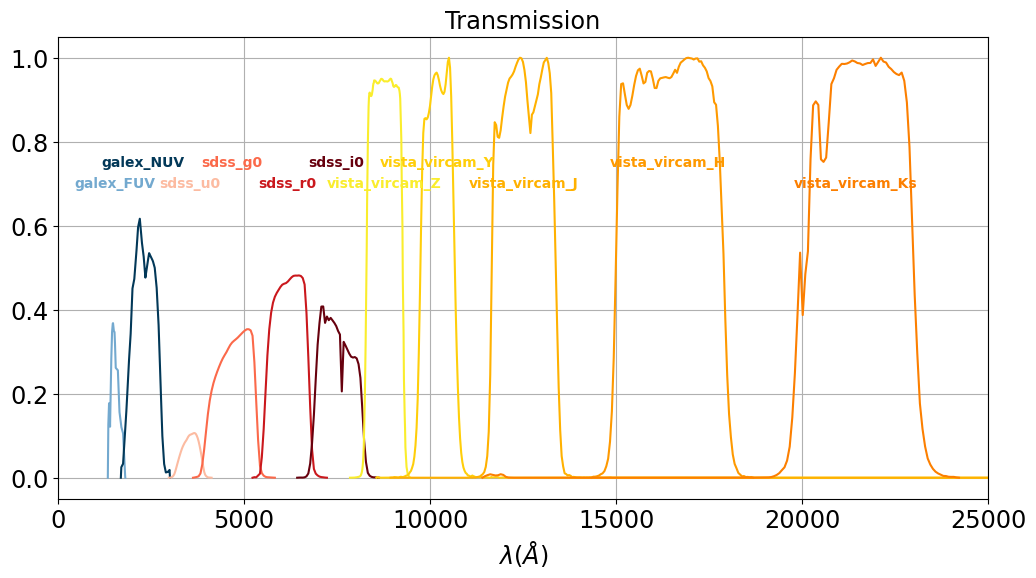

In [18]:
ps.plot_transmissions()
ps.dump()

# transform the FilterInfo object into a pytree

In [19]:
pt_filters = ps.get_pytree()

In [20]:
leaves = jax.tree_leaves(pt_filters)

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_25169/4036315153.py:1: DeprecationWarning: jax.tree_leaves is deprecated: use jax.tree_util.tree_leaves.
  leaves = jax.tree_leaves(pt_filters)


In [21]:
#leaves

# Read Fors2 / Galex and Kids

In [22]:
input_file_h5  = '../../data/fors2sl/FORS2spectraGalexKidsPhotom.hdf5'

In [23]:
fors2 = Fors2DataAcess(input_file_h5)

In [24]:
list_of_keys = fors2.get_list_of_groupkeys()
list_of_attributes = fors2.get_list_subgroup_keys()

## Must sort spectra name

In [25]:
list_of_keys = np.array(list_of_keys)

In [26]:
list_of_keysnum = [ int(re.findall("SPEC(.*)",specname)[0]) for specname in  list_of_keys ]

In [27]:
sorted_indexes = np.argsort(list_of_keysnum)

In [28]:
list_of_keys = list_of_keys[sorted_indexes]

In [29]:
df_info = pd.DataFrame(columns=list_of_attributes)
all_df = []

### Read each spectrum Fors2 as (wl,fnu)

In [30]:
for idx,key in enumerate(list_of_keys):
    attrs = fors2.getattribdata_fromgroup(key)
    spectr = fors2.getspectrum_fromgroup(key)
    df_info.loc[idx] = [*attrs.values()] # hope the order of attributes is kept
    df = pd.DataFrame({"wl":spectr["wl"],"fnu":spectr["fnu"]})
    all_df.append(df)
    

/Users/dagoret/anaconda3/envs/conda_jaxcpu_dsps_py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/dagoret/anaconda3/envs/conda_jaxcpu_dsps_py310/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [31]:
df_info.reset_index(drop=True, inplace=True) 

In [32]:
df_info = df_info[ordered_keys]

In [33]:
df_info

,name,num,ra,dec,redshift,Rmag,RT,RV,eRV,Nsp,...,FLUXERR_GAAP_Z,FLUXERR_GAAP_Y,FLUXERR_GAAP_J,FLUXERR_GAAP_H,FLUXERR_GAAP_Ks,FLUX_RADIUS,EXTINCTION_u,EXTINCTION_g,EXTINCTION_r,EXTINCTION_i
0,SPEC2,2,13.52997,-28.44776,0.34555,21.18,12.3,103665,40,1,...,179.816220,356.027740,290.613160,594.538760,694.397200,2.967994,0.072517,0.056505,0.039090,0.029048
1,SPEC3,3,13.52552,-28.42080,0.68660,21.45,11.6,210642,48,4,...,179.913452,352.837769,287.987885,588.559448,685.337463,3.020974,0.075065,0.058490,0.040463,0.030069
2,SPEC9,9,13.50219,-28.40641,0.29266,21.60,13.1,87798,58,1,...,185.288483,330.740845,268.486725,579.864075,606.197693,2.671784,0.074299,0.057893,0.040050,0.029762
3,SPEC13,13,13.49261,-28.38272,0.68870,23.14,0.0,206610,0,1,...,180.381531,323.638702,260.288177,NaN,NaN,2.192928,0.077572,0.060444,0.041815,0.031073
4,SPEC19,19,13.60758,-28.43452,0.48395,21.70,7.1,145185,104,1,...,123.689148,238.951889,225.177338,544.024658,507.931976,2.992076,0.075642,0.058940,0.040774,0.030300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,SPEC734,734,13.68083,-28.23290,0.23012,0.00,7.2,69036,71,1,...,98.486717,243.505157,196.822708,461.214691,495.400299,3.462931,0.073033,0.056906,0.039368,0.029254
546,SPEC735,735,13.69958,-28.23161,0.36169,19.28,8.2,108507,107,1,...,102.504509,254.145142,206.989441,479.774139,521.821655,3.587435,0.072326,0.056356,0.038987,0.028971
547,SPEC736,736,13.66431,-28.22849,0.55777,21.64,10.5,167331,31,1,...,108.492714,222.538773,185.683838,429.756744,456.459747,4.769248,0.074087,0.057728,0.039936,0.029677
548,SPEC737,737,13.62722,-28.22692,0.52001,21.40,10.2,156003,53,1,...,105.423523,216.082657,179.259644,419.079620,434.556122,2.864109,0.079347,0.061827,0.042772,0.031784


# Select good match with galex

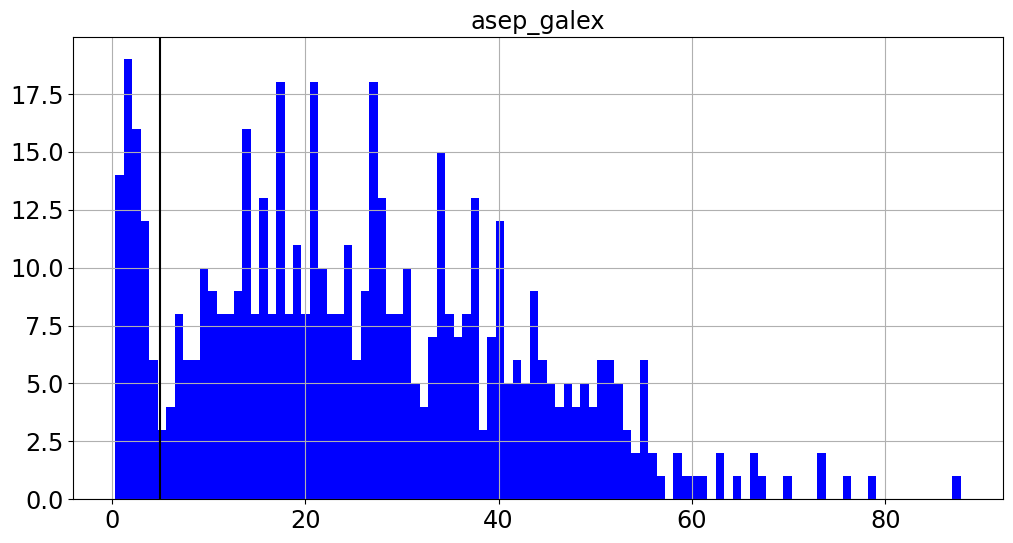

In [34]:
df_info.hist("asep_galex",bins=100,color="b")
plt.axvline(5,c="k")

array([[<Axes: title={'center': 'asep_kids'}>]], dtype=object)

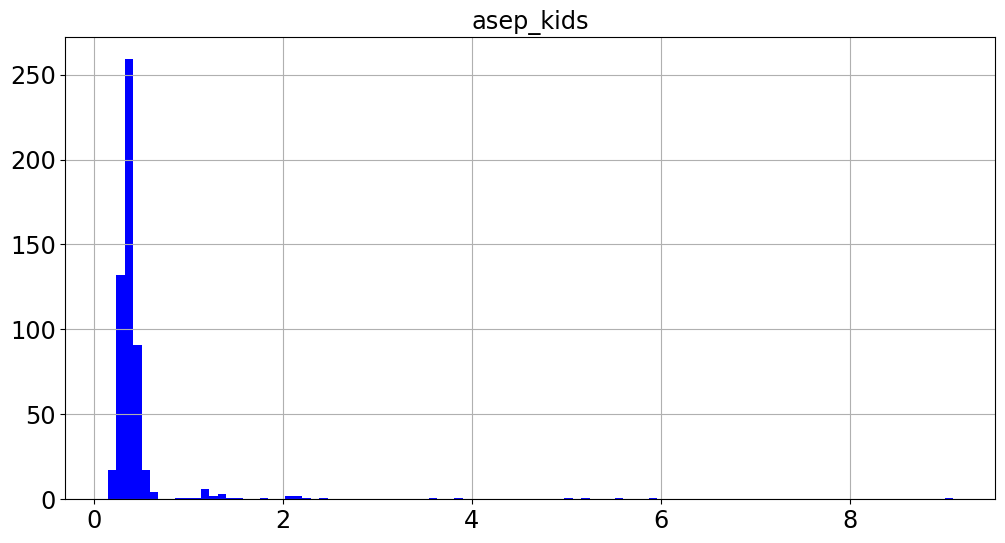

In [35]:
df_info.hist("asep_kids",bins=100,color='b')

## Select  Those spectra having GALEX

In [36]:
df = df_info[df_info["asep_galex"] <= 5]

In [37]:
df.index

Index([ 13,  38,  70,  98,  99, 113, 158, 159, 163, 171, 172, 182, 193, 205,
       210, 215, 228, 232, 241, 243, 244, 245, 253, 256, 257, 263, 275, 276,
       278, 285, 292, 312, 313, 316, 331, 345, 348, 382, 384, 386, 387, 395,
       409, 411, 413, 416, 425, 428, 431, 442, 458, 459, 461, 463, 469, 473,
       480, 483, 504, 511, 512, 528, 530, 533, 535, 536, 538, 543],
      dtype='int64')

## Remove NaN

- remove those row with no FUV

In [38]:
#df = df.dropna()

## Remove rows with Rmag = 0

In [39]:
#df = df[df["Rmag"] > 0]

# Plot Spectra

https://en.wikipedia.org/wiki/Photometric_system

In [40]:
lambda_FUV = 1528.
lambda_NUV = 2271.
lambda_U = 3650.
lambda_B = 4450.
lambda_G = 4640.
lambda_R = 5580.
lambda_I = 8060.
lambda_Z = 9000.
lambda_Y = 10200.
lambda_J = 12200.
lambda_H = 16300.
lambda_K = 21900.
lambda_L = 34500.

WL = [lambda_FUV, lambda_NUV, lambda_B, lambda_G, lambda_R ,lambda_I, lambda_Z, lambda_Y, lambda_J, lambda_H, lambda_K ]
FilterTag = ['FUV','NUV','B','G','R','I','Z','Y','J','H','Ks']

In [41]:
def PlotFilterTag(ax,fluxlist):
    goodfl = fluxlist[np.isfinite(fluxlist)]
    ymin = np.mean(goodfl)
    dy=ymin/5
   
    for idx,flux in enumerate(fluxlist):
        if np.isfinite(flux):
            #ax.text(WL[idx],flux, FilterTag[idx],fontsize=10,ha='center', va='bottom')
                     
            fl = flux - dy
            if fl <0:
                fl += 2*dy
            ax.text(WL[idx],fl, FilterTag[idx],fontsize=12,color="g",weight='bold',ha='center', va='bottom')
            

In [42]:
df

,name,num,ra,dec,redshift,Rmag,RT,RV,eRV,Nsp,...,FLUXERR_GAAP_Z,FLUXERR_GAAP_Y,FLUXERR_GAAP_J,FLUXERR_GAAP_H,FLUXERR_GAAP_Ks,FLUX_RADIUS,EXTINCTION_u,EXTINCTION_g,EXTINCTION_r,EXTINCTION_i
13,SPEC36,36,13.56870,-28.43129,0.82266,19.96,13.0,246798,80,1,...,175.896149,340.098511,277.472107,570.941833,660.577942,4.946754,0.075650,0.058946,0.040779,0.030303
38,SPEC85,85,13.53755,-28.38375,0.97900,23.21,0.0,0,0,1,...,180.088974,323.638702,260.301910,556.272217,609.571655,1.904666,0.080195,0.062487,0.043228,0.032123
70,SPEC151,151,13.54459,-28.38795,0.49762,22.23,11.1,149286,33,1,...,184.057159,332.456512,269.498627,576.139160,628.552673,3.000832,0.080068,0.062388,0.043160,0.032072
98,SPEC214,214,13.54850,-28.42296,0.29266,19.80,16.1,87798,23,1,...,178.927719,348.236633,284.142151,584.317017,679.517578,4.766320,0.076636,0.059715,0.041310,0.030698
99,SPEC218,218,13.54348,-28.43490,0.43800,21.27,0.0,131400,0,1,...,189.295288,375.119659,309.391968,636.975586,740.847229,4.821135,0.073811,0.057513,0.039787,0.029566
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
533,SPEC722,722,13.69932,-28.26123,1.21050,20.99,17.5,363150,234,1,...,123.030487,253.777481,205.343628,464.147339,514.735779,2.023525,0.071443,0.055668,0.038511,0.028618
535,SPEC724,724,13.66411,-28.25705,0.23168,21.07,13.5,69504,36,1,...,118.080482,242.339783,191.391754,440.170135,480.001190,3.872675,0.070691,0.055082,0.038105,0.028316
536,SPEC725,725,13.69168,-28.25586,0.23010,20.86,14.1,69030,29,1,...,122.323341,252.362854,204.230362,465.261749,512.764404,4.971230,0.071652,0.055831,0.038623,0.028701
538,SPEC727,727,13.69381,-28.25005,0.23060,22.59,5.9,69180,81,1,...,127.273331,261.258026,214.011581,488.609253,536.854980,3.747046,0.070389,0.054846,0.037942,0.028195


In [43]:
df['index0'] = df.index
df = df.reset_index()

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_25169/1867917747.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['index0'] = df.index


In [44]:
df['index0']

0      13
1      38
2      70
3      98
4      99
     ... 
63    533
64    535
65    536
66    538
67    543
Name: index0, Length: 68, dtype: int64

In [45]:
df.columns

Index(['index', 'name', 'num', 'ra', 'dec', 'redshift', 'Rmag', 'RT', 'RV',
       'eRV', 'Nsp', 'lines', 'ra_galex', 'dec_galex', 'fuv_mag', 'fuv_magerr',
       'nuv_mag', 'nuv_magerr', 'fuv_flux', 'fuv_fluxerr', 'nuv_flux',
       'nuv_fluxerr', 'asep_galex', 'ID', 'KIDS_TILE', 'RAJ2000', 'DECJ2000',
       'Z_ML', 'Z_B', 'asep_kids', 'CLASS_STAR', 'MAG_GAAP_u', 'MAG_GAAP_g',
       'MAG_GAAP_r', 'MAG_GAAP_i', 'MAG_GAAP_Z', 'MAG_GAAP_Y', 'MAG_GAAP_J',
       'MAG_GAAP_H', 'MAG_GAAP_Ks', 'MAGERR_GAAP_u', 'MAGERR_GAAP_g',
       'MAGERR_GAAP_r', 'MAGERR_GAAP_i', 'MAGERR_GAAP_Z', 'MAGERR_GAAP_Y',
       'MAGERR_GAAP_J', 'MAGERR_GAAP_H', 'MAGERR_GAAP_Ks', 'FLUX_GAAP_u',
       'FLUX_GAAP_g', 'FLUX_GAAP_r', 'FLUX_GAAP_i', 'FLUX_GAAP_Z',
       'FLUX_GAAP_Y', 'FLUX_GAAP_J', 'FLUX_GAAP_H', 'FLUX_GAAP_Ks',
       'FLUXERR_GAAP_u', 'FLUXERR_GAAP_g', 'FLUXERR_GAAP_r', 'FLUXERR_GAAP_i',
       'FLUXERR_GAAP_Z', 'FLUXERR_GAAP_Y', 'FLUXERR_GAAP_J', 'FLUXERR_GAAP_H',
       'FLUXERR_GAAP_Ks', 'FL

# Plots

## Fit Gaussian process to remove abs lines

In [46]:
kernel = kernels.RBF(0.5, (8000, 10000.0))
gp = GaussianProcessRegressor(kernel=kernel ,random_state=0)

### Select Spectrum

In [47]:
#selected_spectrum_number = 411
selected_spectrum_number = 560

dict_normalisation_factor = {}
dict_normalisation_factor[411] = 160.
dict_normalisation_factor[560] = 12.

/Users/dagoret/anaconda3/envs/conda_jaxcpu_dsps_py310/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:429: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 10000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


0  ==  SPEC36 36 13
1  ==  SPEC85 85 38
2  ==  SPEC151 151 70
3  ==  SPEC214 214 98
4  ==  SPEC218 218 99
5  ==  SPEC242 242 113
6  ==  SPEC306 306 158
7  ==  SPEC307 307 159
8  ==  SPEC315 315 163
9  ==  SPEC325 325 171
10  ==  SPEC326 326 172
11  ==  SPEC337 337 182
12  ==  SPEC350 350 193
13  ==  SPEC363 363 205
14  ==  SPEC368 368 210
15  ==  SPEC373 373 215
16  ==  SPEC386 386 228
17  ==  SPEC390 390 232
18  ==  SPEC399 399 241
19  ==  SPEC401 401 243
20  ==  SPEC402 402 244
21  ==  SPEC403 403 245
22  ==  SPEC411 411 253
23  ==  SPEC414 414 256
24  ==  SPEC415 415 257
25  ==  SPEC421 421 263
26  ==  SPEC434 434 275
27  ==  SPEC435 435 276
28  ==  SPEC437 437 278
29  ==  SPEC444 444 285
30  ==  SPEC451 451 292
31  ==  SPEC471 471 312
32  ==  SPEC472 472 313
33  ==  SPEC476 476 316
34  ==  SPEC499 499 331
35  ==  SPEC516 516 345
36  ==  SPEC519 519 348
37  ==  SPEC558 558 382
38  ==  SPEC560 560 384
the_lines =  b'G,H{beta},Mgb,NaD                                                   

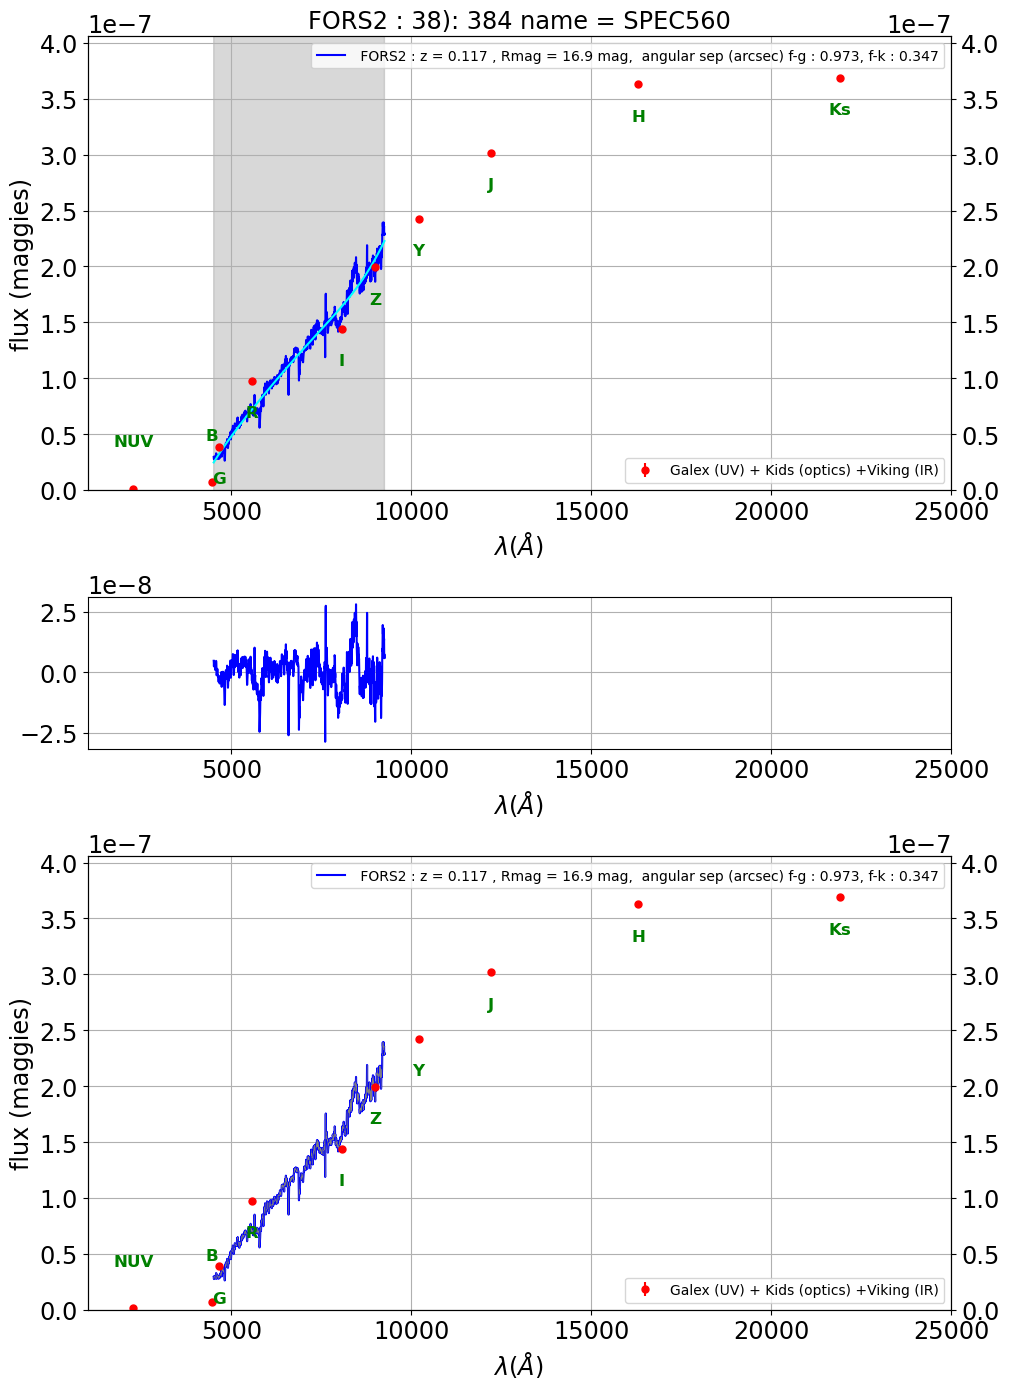

39  ==  SPEC563 563 386


In [48]:
# loop on rows
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
for idx,row in df.iterrows():
    
    print(idx," == ",row["name"],row["num"],row["index0"])
    idx0 = row["index0"] # index for the spectrum
    specname  = row["name"]
    specnum = row["num"]
    if specnum < selected_spectrum_number:
        continue
    if specnum > selected_spectrum_number:
        break
    
    
    mags = np.array([ row["fuv_mag"], row["nuv_mag"], row['MAG_GAAP_u'], row['MAG_GAAP_g'], row['MAG_GAAP_r'], row['MAG_GAAP_i'], row['MAG_GAAP_Z'], row['MAG_GAAP_Y'], 
            row['MAG_GAAP_J'], row['MAG_GAAP_H'],row['MAG_GAAP_Ks'] ])
    
    magserr = np.array([ row["fuv_magerr"], row["nuv_magerr"], row['MAGERR_GAAP_u'], row['MAGERR_GAAP_g'], row['MAGERR_GAAP_r'], row['MAGERR_GAAP_i'], row['MAGERR_GAAP_Z'], row['MAGERR_GAAP_Y'], 
            row['MAGERR_GAAP_J'], row['MAGERR_GAAP_H'],row['MAGERR_GAAP_Ks'] ])
    
    mfluxes = [ 10**(-0.4*m) for m in mags ]
    mfluxeserr = []
    
    for f,em in zip(mfluxes,magserr):
        ferr = 0.4*np.log(10)*em*f
        mfluxeserr.append(ferr)
        
    mfluxes = np.array(mfluxes)
    mfluxeserr = np.array(mfluxeserr)
    
    fluxes =  [ row["fuv_flux"], row["nuv_flux"], row['FLUX_GAAP_u'], row['FLUX_GAAP_g'], row['FLUX_GAAP_r'], row['FLUX_GAAP_i'], row['FLUX_GAAP_Z'], row['FLUX_GAAP_Y'], 
            row['FLUX_GAAP_J'], row['FLUX_GAAP_H'],row['FLUX_GAAP_Ks'] ]
    
    fluxeserr =  [ row["fuv_fluxerr"], row["nuv_fluxerr"], row['FLUXERR_GAAP_u'], row['FLUXERR_GAAP_g'], row['FLUXERR_GAAP_r'], row['FLUXERR_GAAP_i'], row['FLUXERR_GAAP_Z'], row['FLUX_GAAP_Y'], 
            row['FLUXERR_GAAP_J'], row['FLUXERR_GAAP_H'],row['FLUXERR_GAAP_Ks'] ]
    
    ##############################################################
    # The top image
    ######################################
    fig = plt.figure(figsize=(10,14),tight_layout=True)
    gs = gridspec.GridSpec(3, 1,height_ratios=[3, 1, 3])
    
    
    #top image : original flux
    ax= fig.add_subplot(gs[0, 0])
    
    z = row["redshift"]
    asep_fg = row['asep_galex']
    rmag = row["Rmag"]
    asep_fk = row['asep_kids']
    
  
    the_lines = row['lines']
    print("the_lines = ",the_lines)
    all_elements  = the_lines.decode().split(",")
    
    
    the_label_data = f" FORS2 : z = {z:.3f} , Rmag = {rmag:.1f} mag,  angular sep (arcsec) f-g : {asep_fg:.3f}, f-k : {asep_fk:.3f}" 
    the_wl = all_df[idx0]["wl"].values
    the_fnu = all_df[idx0]["fnu"].values*10**(-0.4*mags[4])    
    ax.plot(the_wl,the_fnu,'b-',label=the_label_data)
     
    X = the_wl
    Y = the_fnu
    
    gp.fit(X[:, None], Y)
    xfit = np.linspace(X.min(),X.max())
    yfit, yfit_err = gp.predict(xfit[:, None], return_std=True)
    ax.plot(xfit, yfit, '-', color='cyan')
    ax.fill_between(xfit, yfit -  yfit_err, yfit +  yfit_err, color='gray', alpha=0.3)
     
    ax2 = ax.twinx()
    ax2.errorbar(WL,mfluxes,yerr=mfluxeserr,fmt='o',color="r",ecolor="r",ms=5,label='Galex (UV) + Kids (optics) +Viking (IR)')
    PlotFilterTag(ax2,mfluxes)
    #ax2.errorbar(WL, fluxes, yerr=fluxes, xerr=None, fmt='o', color="g",ecolor="g")
    ax2.legend(loc="lower right")
    
    ax.set_xlabel("$\lambda  (\AA)$ ")
    title_data = f"FORS2 : {idx}): {idx0} name = {specname}"
    ax.set_title(title_data)
    ax.set_ylabel("flux (maggies)")
    ax.legend(loc="upper right")
    ax.grid()
    
    the_max1 = np.max(the_fnu)
    goodmags = mfluxes[np.isfinite(mfluxes)]
    the_max2 = np.max(goodmags)
    the_max = 1.1*max(the_max1,the_max2)

    ax.set_ylim(0,the_max)
    ax2.set_ylim(0,the_max)

    ax.set_xlim(1000.,25000.)
    ##################
    # Middle image : Fit a gaussian process and compute the residuals
    ##################
    ax3 = fig.add_subplot(gs[1, 0])
    DeltaY,DeltaEY = Y - gp.predict(X[:, None], return_std=True)
    ax3.plot(X,DeltaY,'b')
    ax3.set_xlim(1000.,25000.)
    ax3.grid()
    ax3.set_xlabel("$\lambda  (\AA)$ ")
    
    background = np.sqrt(np.median(DeltaY**2))
    indexes_toremove = np.where(np.abs(DeltaY)> 8 * background)[0]
    
    for index in indexes_toremove:
        ax3.axvline(X[index],color='k')
    
    #########################    
    # Bottom image : resuting image after removing emission lines
    #########################
    
    ax4 = fig.add_subplot(gs[2, 0])
    
    Xclean = np.delete(X,indexes_toremove)
    Yclean  = np.delete(Y,indexes_toremove)
    
    ax4.plot(Xclean, Yclean,'b-',label=the_label_data)
    ax4.set_ylim(0,the_max)
    ax4.set_xlim(1000.,25000.)
    ax4.grid()
    ax4.set_xlabel("$\lambda  (\AA)$ ")
    
    ax5 = ax4.twinx()
    ax5.errorbar(WL,mfluxes,yerr=mfluxeserr,fmt='o',color="r",ecolor="r",ms=5,label='Galex (UV) + Kids (optics) +Viking (IR)')
    ax5.legend(loc="lower right")
    ax5.set_ylim(0,the_max)
    PlotFilterTag(ax5,mfluxes)
    
    ax4.set_ylabel("flux (maggies)")
    ax4.legend(loc="upper right")
    
    spectr = fors2.getspectrumcleanedemissionlines_fromgroup(specname,gp)

    the_wl = all_df[idx0]["wl"].values
    the_fnu = all_df[idx0]["fnu"].values*10**(-0.4*mags[4])
    
    ax5.plot(the_wl,the_fnu,color="grey",lw=0.25,label="original")

    
    plt.show()

In [49]:
mags

array([        nan, 22.208868  , 20.40005302, 18.52657318, 17.52623177,
       17.10333824, 16.75155258, 16.5380497 , 16.30030441, 16.10061455,
       16.08258629])

In [50]:
magserr 

array([       nan, 0.46131718, 0.02466832, 0.00148731, 0.00068724,
       0.00172874, 0.00133276, 0.00214728, 0.00178616, 0.00279078,
       0.00308301])

In [51]:
background 

3.965287988999036e-09

In [52]:
z

0.11731

# Model of a galaxy

### Load SED templates

In [53]:

#ssp_data = load_ssp_templates(fn='tempdata_v2.h5')
ssp_data = load_ssp_templates(fn='../examples_dsps_diffstar_diffmah/tempdata.h5')

print(ssp_data._fields)

print('ssp_data : ssp_lgmet.shape = {}'.format(ssp_data.ssp_lgmet.shape))
print('ssp_data : ssp_lg_age_gyr.shape = {}'.format(ssp_data.ssp_lg_age_gyr.shape))
print('ssp_data : ssp_wave.shape = {}'.format(ssp_data.ssp_wave.shape))
print('ssp_data :ssp_flux.shape = {}'.format(ssp_data.ssp_flux.shape))

('ssp_lgmet', 'ssp_lg_age_gyr', 'ssp_wave', 'ssp_flux')
ssp_data : ssp_lgmet.shape = (12,)
ssp_data : ssp_lg_age_gyr.shape = (107,)
ssp_data : ssp_wave.shape = (5994,)
ssp_data :ssp_flux.shape = (12, 107, 5994)


### calculate age distribution

In [54]:
today_gyr = 13.8 
tarr = np.linspace(0.1, today_gyr, 100)

In [55]:
sfh_gal = sfh_singlegal(tarr, DEFAULT_MAH_PARAMS, DEFAULT_MS_PARAMS, DEFAULT_Q_PARAMS)

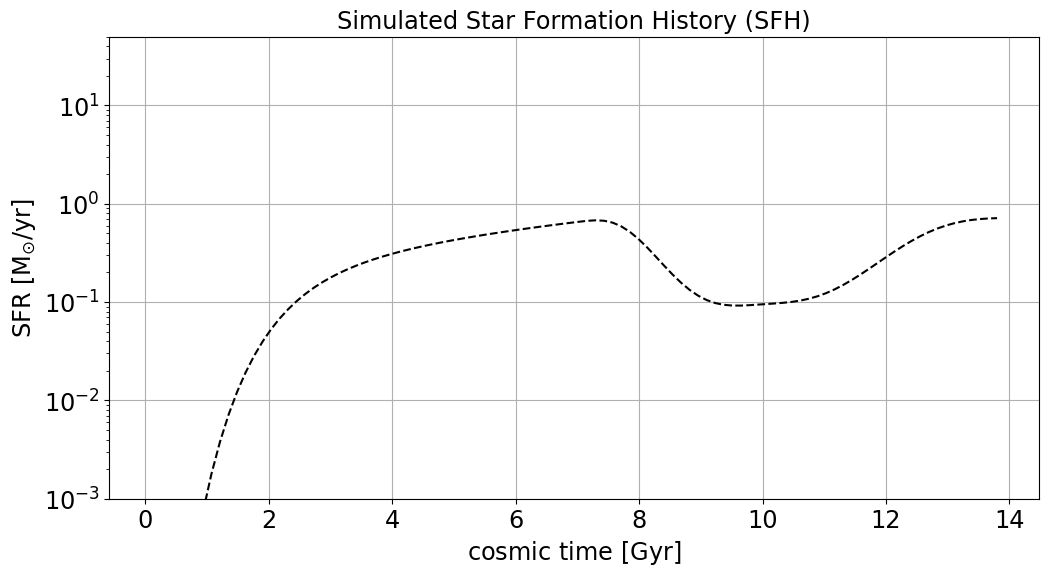

In [56]:
fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(1e-3, 50)
yscale = ax.set_yscale('log')

__=ax.plot(tarr, sfh_gal, '--', color='k',label='sfh_gal')
ax.set_title("Simulated Star Formation History (SFH)")
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'${\rm SFR\ [M_{\odot}/yr]}$')
ax.grid()

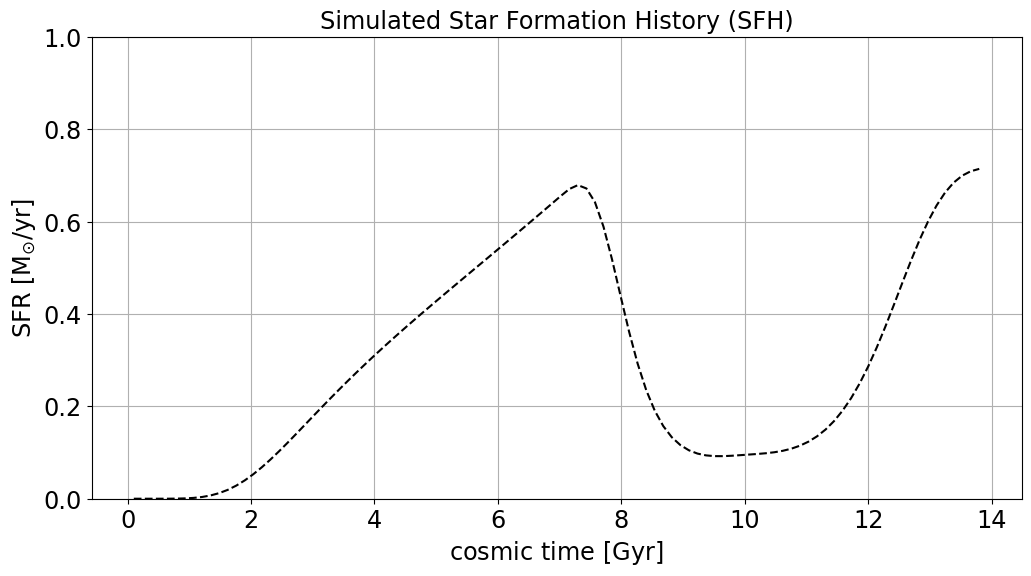

In [57]:
fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(0, 1)
#yscale = ax.set_yscale('log')

__=ax.plot(tarr, sfh_gal, '--', color='k',label='sfh_gal')
ax.set_title("Simulated Star Formation History (SFH)")
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'${\rm SFR\ [M_{\odot}/yr]}$')
ax.grid()

In [58]:
gal_t_table = tarr

In [59]:
z_obs = z
t_obs = age_at_z(z_obs, *DEFAULT_COSMOLOGY) # age of the universe in Gyr at z_obs
t_obs = t_obs[0] # age_at_z function returns an array, but SED functions accept a float for this argument

In [60]:
sfh_gal = jnp.where(tarr<t_obs, sfh_gal, 0)

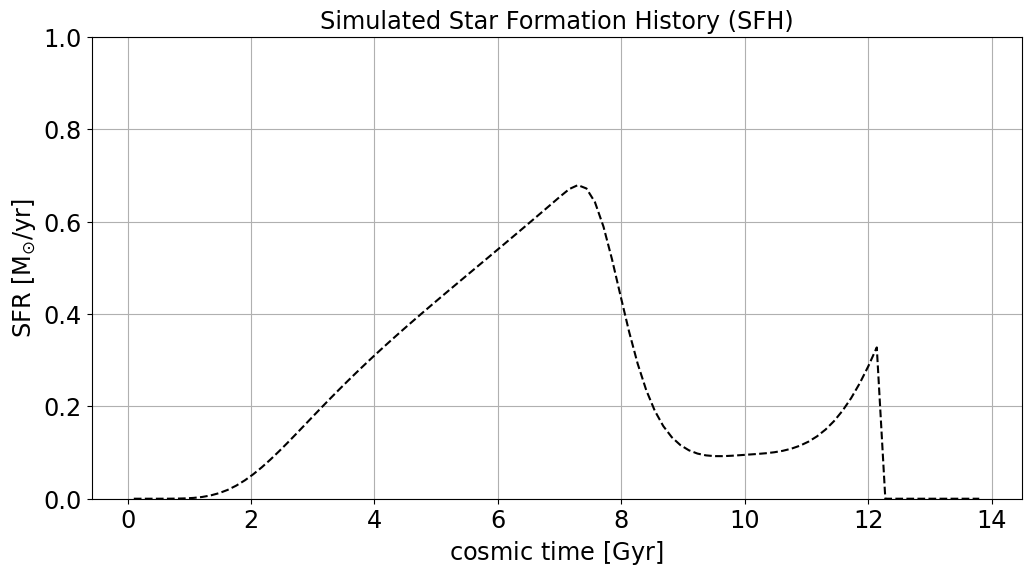

In [61]:
fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(0, 1)
#yscale = ax.set_yscale('log')

__=ax.plot(tarr, sfh_gal, '--', color='k',label='sfh_gal')
ax.set_title("Simulated Star Formation History (SFH)")
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'${\rm SFR\ [M_{\odot}/yr]}$')
ax.grid()

In [62]:
gal_sfr_table = sfh_gal
# metallicity
gal_lgmet = -2.0 # log10(Z)
gal_lgmet_scatter = 0.2 # lognormal scatter in the metallicity distribution function


In [63]:
# calculate first SED with only one metallicity
print("gal_lgmet = ", gal_lgmet)

sed_info = calc_rest_sed_sfh_table_lognormal_mdf(
    gal_t_table, gal_sfr_table, gal_lgmet, gal_lgmet_scatter,
    ssp_data.ssp_lgmet, ssp_data.ssp_lg_age_gyr, ssp_data.ssp_flux, t_obs)

gal_lgmet =  -2.0


In [64]:
Av= 1.0
uv_bump_ampl = 3.0
plaw_slope = -0.25
wave_spec_micron = ssp_data.ssp_wave/10_000

In [65]:
k = sbl18_k_lambda(wave_spec_micron,uv_bump_ampl,plaw_slope)
dsps_flux_ratio = _frac_transmission_from_k_lambda(k,Av)

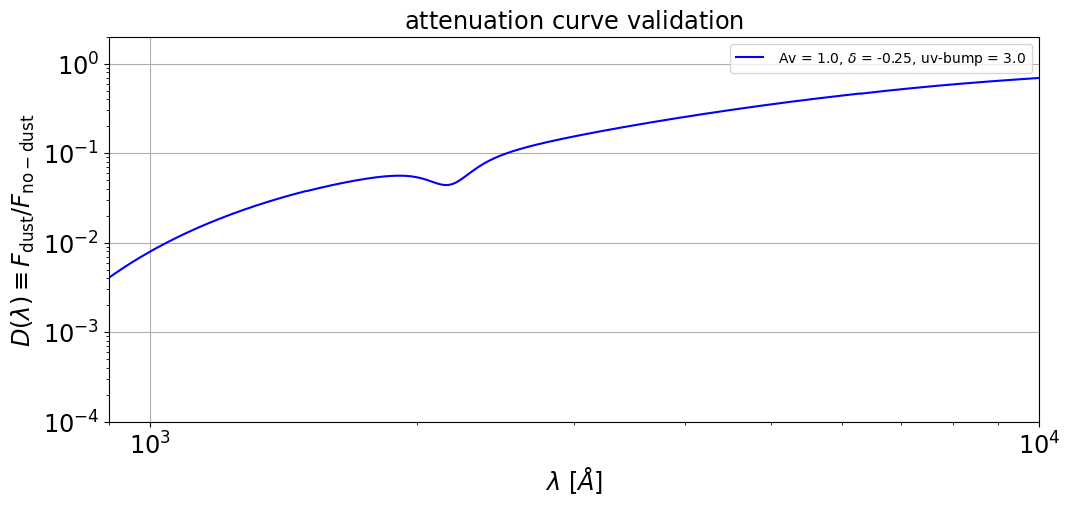

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
# fig.tight_layout(pad=3.0)

label_dust = f" Av = {Av}, $\delta$ = {plaw_slope}, uv-bump = {uv_bump_ampl}"
ax.plot(ssp_data.ssp_wave ,dsps_flux_ratio,'b-',label=label_dust)

xlim = ax.set_xlim(900, 1e4)
ylim = ax.set_ylim(1e-4, 2)
__=ax.loglog()

title = ax.set_title(r'${\rm attenuation\ curve\ validation}$')
xlabel = ax.set_xlabel(r'$\lambda\ [\AA]$')
ylabel= ax.set_ylabel(r'$D(\lambda)\equiv F_{\rm dust}/F_{\rm no-dust}$')
ax.legend()
ax.grid()

In [67]:
sed_attenuated = dsps_flux_ratio * sed_info.rest_sed

In [68]:
FLAG_RESCALE_FORPLOT = False

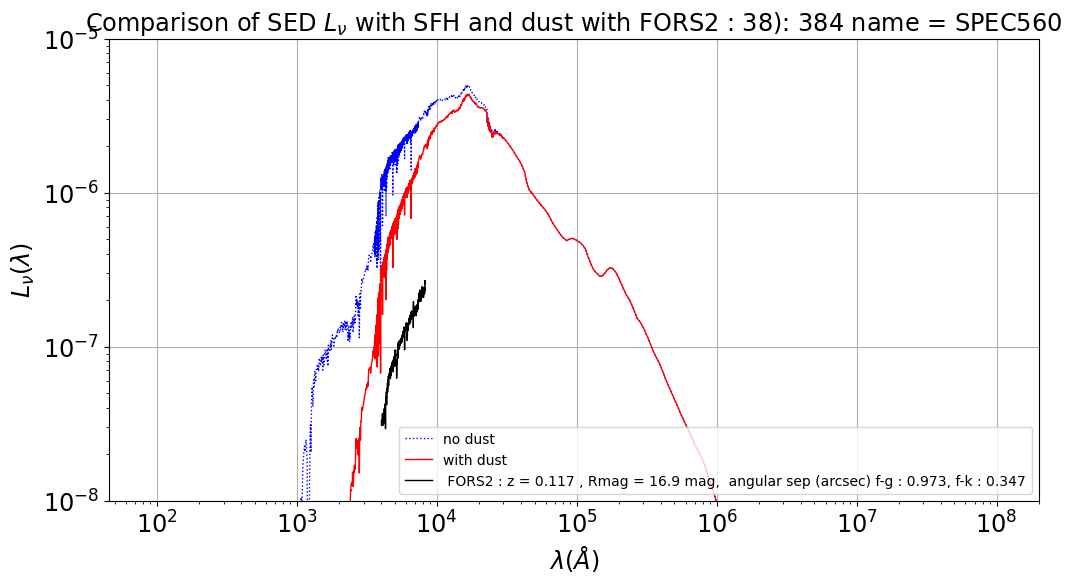

In [69]:
fig, ax = plt.subplots(1, 1)
__=ax.loglog()
__=ax.plot(ssp_data.ssp_wave, sed_info.rest_sed,'b:',lw=1,label="no dust")
__=ax.plot(ssp_data.ssp_wave, sed_attenuated,'r-',lw=1,label="with dust")
__=ax.set_ylim(1e-8,1e-5)
ax.set_xlabel("$\lambda (\\AA)$")
ax.set_ylabel("$L_\\nu(\lambda)$")

if FLAG_RESCALE_FORPLOT : 
    X = the_wl/(1+z_obs)
    Y = the_fnu*(1+z)*dict_normalisation_factor[selected_spectrum_number]
else:
    X = the_wl/(1+z_obs)
    Y = the_fnu*(1+z)
 
ax.plot(X,Y,'k-',lw=1,label=the_label_data)
ax.legend()

title = "Comparison of SED $L_\\nu$ with SFH and dust with " + title_data
ax.set_title(title)
ax.grid()

### Extract quantities for the experimental spectra in Fnu

In [70]:
Xspec_data = copy.deepcopy(X)
Yspec_data = copy.deepcopy(Y)
EYspec_data = background

### Check the calculation of magnitudes inside the filters

In [71]:
for index,filtname in enumerate(ps.filters_galex):
    the_filt = ps.all_filt_galex[index]
    obs_mag = calc_obs_mag(ssp_data.ssp_wave, sed_attenuated, the_filt.wavelength, the_filt.transmission,
                      z_obs, *DEFAULT_COSMOLOGY)
    print(ps.filters_galex[index]," : " ,f"{obs_mag:.2f} mag")
    
for index,filtname in enumerate(ps.filters_sdss):
    the_filt = ps.all_filt_sdss[index]
    obs_mag = calc_obs_mag(ssp_data.ssp_wave, sed_attenuated, the_filt.wavelength, the_filt.transmission,
                      z_obs, *DEFAULT_COSMOLOGY)
    print(ps.filters_sdss[index]," : " ,f"{obs_mag:.2f} mag")      

for index,filtname in enumerate(ps.filters_vircam):
    the_filt = ps.all_filt_vircam[index]
    obs_mag = calc_obs_mag(ssp_data.ssp_wave, sed_attenuated, the_filt.wavelength, the_filt.transmission,
                      z_obs, *DEFAULT_COSMOLOGY)
    print(ps.filters_vircam[index]," : " ,f"{obs_mag:.2f} mag")      

galex_FUV  :  28.09 mag
galex_NUV  :  26.68 mag
sdss_u0  :  24.37 mag
sdss_g0  :  22.47 mag
sdss_r0  :  21.52 mag
sdss_i0  :  21.05 mag
vista_vircam_Z  :  20.64 mag
vista_vircam_Y  :  20.33 mag
vista_vircam_J  :  20.09 mag
vista_vircam_H  :  19.87 mag
vista_vircam_Ks  :  19.85 mag


In [72]:
#X = the_wl/(1+z_obs)
#Y = the_fnu*(1+z)

# Start Optimisation in JaxOpt

### Parameters

In [73]:
def paramslist_to_dict(params_list,param_names):
    """
    Convert the list of parameters into a dictionnary
    :param params_list: list of params values
    :type params_list: float in an array

    :param param_names: list of parameter names
    :type params_names: strings in an array

    :return: dictionnary of parameters
    :rtype: dictionnary
    """
    
    Nparams = len(params_list)
    list_of_tuples = list(zip(param_names,params_list))
    print(list_of_tuples)
    dict_params = OrderedDict(list_of_tuples )
    return dict_params
            

#### MAH parameters
model for the mass assembly history of individual and populations of dark matter halos

In [74]:
DEFAULT_MAH_PARAMS

array([12.  ,  0.05,  2.5 ,  1.  ])

In [75]:
DEFAULT_MAH_PARAMS_MIN = DEFAULT_MAH_PARAMS + np.array([-3., -0.01, -1.5,-0.5])
DEFAULT_MAH_PARAMS_MAX = DEFAULT_MAH_PARAMS + np.array([2., +0.01, +1.5,+0.5])

In [76]:
mah_paramnames = ["MAH_lgmO","MAH_logtc","MAH_early_index","MAH_late_index"]

#### MS parameters

In [77]:
DEFAULT_MS_PARAMS

array([12., -1.,  1., -1.,  2.])

In [78]:
DEFAULT_MS_PARAMS_MIN = DEFAULT_MS_PARAMS - 0.25*np.ones((5)) 
DEFAULT_MS_PARAMS_MAX = DEFAULT_MS_PARAMS + 0.25*np.ones((5)) 

In [79]:
ms_paramnames = ["MS_lgmcrit", "MS_lgy_at_mcrit", "MS_indx_lo", "MS_indx_hi", "MS_tau_dep"]

#### Q parameters
Quenching parameters

In [80]:
DEFAULT_Q_PARAMS

array([ 1.      , -0.50725 , -1.01773 , -0.212307])

In [81]:
DEFAULT_Q_PARAMS_MIN = DEFAULT_Q_PARAMS - 0.1*np.ones((4,))
DEFAULT_Q_PARAMS_MAX = DEFAULT_Q_PARAMS + 0.1*np.ones((4,))

In [82]:
q_paramnames = ["Q_lg_qt", "Q_qlglgdt", "Q_lg_drop", "Q_lg_rejuv"]

#### Dust parameters

In [83]:
Av= 1
uv_bump_ampl = 2.0
plaw_slope = -0.25

In [84]:
DEFAULT_DUST_PARAMS = [Av, uv_bump_ampl, plaw_slope]

In [85]:
DEFAULT_DUST_PARAMS_MIN = DEFAULT_DUST_PARAMS + np.array([-1.,-1.,-0.1])
DEFAULT_DUST_PARAMS_MAX = DEFAULT_DUST_PARAMS + np.array([2.,1.,0.25])

In [86]:
dust_paramnames = ["Av", "uv_bump", "plaw_slope"]

#### Scaling parameter

In [87]:
scaleF = 1.0

In [88]:
DEFAULT_SCALEF_PARAMS = np.array([scaleF])
DEFAULT_SCALEF_PARAMS_MIN = DEFAULT_SCALEF_PARAMS + np.array([0.001])
DEFAULT_SCALEF_PARAMS_MAX = DEFAULT_SCALEF_PARAMS + np.array([1000.])

In [89]:
scale_paramnames = ["scaleF"]

#### Combine parameters

In [90]:
defaults_params = [DEFAULT_MAH_PARAMS,DEFAULT_MS_PARAMS,DEFAULT_Q_PARAMS,DEFAULT_DUST_PARAMS, DEFAULT_SCALEF_PARAMS ]

params_min = np.concatenate(([DEFAULT_MAH_PARAMS_MIN,DEFAULT_MS_PARAMS_MIN,DEFAULT_Q_PARAMS_MIN,DEFAULT_DUST_PARAMS_MIN,DEFAULT_SCALEF_PARAMS_MIN]))
params_max = np.concatenate(([DEFAULT_MAH_PARAMS_MAX,DEFAULT_MS_PARAMS_MAX,DEFAULT_Q_PARAMS_MAX,DEFAULT_DUST_PARAMS_MAX,DEFAULT_SCALEF_PARAMS_MAX]))
init_params = np.concatenate(defaults_params)
init_params = jnp.array(init_params)

param_names = [mah_paramnames,ms_paramnames,q_paramnames,dust_paramnames,scale_paramnames]
param_scales = [3, 0.25,0.1,2.]

In [91]:
dict_param_mah_true = OrderedDict([(mah_paramnames[0],DEFAULT_MAH_PARAMS[0]),
                                         (mah_paramnames[1],DEFAULT_MAH_PARAMS[1]),
                                         (mah_paramnames[2],DEFAULT_MAH_PARAMS[2]),
                                         (mah_paramnames[3],DEFAULT_MAH_PARAMS[3])
                                         ])
dict_param_mah_true_selected = OrderedDict([(mah_paramnames[0],DEFAULT_MAH_PARAMS[0]),
                                         ])
dict_param_ms_true = OrderedDict([(ms_paramnames[0],DEFAULT_MS_PARAMS[0]),
                                         (ms_paramnames[1],DEFAULT_MS_PARAMS[1]),
                                         (ms_paramnames[2],DEFAULT_MS_PARAMS[2]),
                                         (ms_paramnames[3],DEFAULT_MS_PARAMS[3]),
                                         (ms_paramnames[4],DEFAULT_MS_PARAMS[4])])
dict_param_q_true = OrderedDict([(q_paramnames[0],DEFAULT_Q_PARAMS[0]),
                                         (q_paramnames[1],DEFAULT_Q_PARAMS[1]),
                                         (q_paramnames[2],DEFAULT_Q_PARAMS[2]),
                                         (q_paramnames[3],DEFAULT_Q_PARAMS[3])])

dict_param_dust_true = OrderedDict([(dust_paramnames[0],DEFAULT_DUST_PARAMS[0]),
                                         (dust_paramnames[1],DEFAULT_DUST_PARAMS[1]),
                                         (dust_paramnames[2],DEFAULT_DUST_PARAMS[2])])
dict_param_dust_true_selected = OrderedDict([(dust_paramnames[0],DEFAULT_DUST_PARAMS[0])])

dict_param_scalef_true = OrderedDict([(scale_paramnames[0],DEFAULT_SCALEF_PARAMS[0]) ])

In [92]:
dict_param_dust_true

OrderedDict([('Av', 1), ('uv_bump', 2.0), ('plaw_slope', -0.25)])

In [93]:
params_true = dict_param_mah_true
params_true.update(dict_param_ms_true)
params_true.update(dict_param_q_true)
params_true.update(dict_param_dust_true)
params_true.update(dict_param_scalef_true)

In [94]:
params_true

OrderedDict([('MAH_lgmO', 12.0),
             ('MAH_logtc', 0.05),
             ('MAH_early_index', 2.5),
             ('MAH_late_index', 1.0),
             ('MS_lgmcrit', 12.0),
             ('MS_lgy_at_mcrit', -1.0),
             ('MS_indx_lo', 1.0),
             ('MS_indx_hi', -1.0),
             ('MS_tau_dep', 2.0),
             ('Q_lg_qt', 1.0),
             ('Q_qlglgdt', -0.50725),
             ('Q_lg_drop', -1.01773),
             ('Q_lg_rejuv', -0.212307),
             ('Av', 1),
             ('uv_bump', 2.0),
             ('plaw_slope', -0.25),
             ('scaleF', 1.0)])

In [95]:
param_names

[['MAH_lgmO', 'MAH_logtc', 'MAH_early_index', 'MAH_late_index'],
 ['MS_lgmcrit', 'MS_lgy_at_mcrit', 'MS_indx_lo', 'MS_indx_hi', 'MS_tau_dep'],
 ['Q_lg_qt', 'Q_qlglgdt', 'Q_lg_drop', 'Q_lg_rejuv'],
 ['Av', 'uv_bump', 'plaw_slope'],
 ['scaleF']]

In [96]:
param_names_flat = list(itertools.chain(*param_names))
param_names_flat

['MAH_lgmO',
 'MAH_logtc',
 'MAH_early_index',
 'MAH_late_index',
 'MS_lgmcrit',
 'MS_lgy_at_mcrit',
 'MS_indx_lo',
 'MS_indx_hi',
 'MS_tau_dep',
 'Q_lg_qt',
 'Q_qlglgdt',
 'Q_lg_drop',
 'Q_lg_rejuv',
 'Av',
 'uv_bump',
 'plaw_slope',
 'scaleF']

In [97]:
def mean_spectrum(wls, params):
    """ Model of spectrum 
    
    :param wls: wavelengths of the spectrum in rest frame
    :type wls: float
    
    :return: the spectrum
    :rtype: float
    
    """
    
    # decode the parameters
    MAH_lgmO = params["MAH_lgmO"]
    MAH_logtc = params["MAH_logtc"]
    MAH_early_index = params["MAH_early_index"]
    MAH_late_index = params["MAH_late_index"]
    list_param_mah = [MAH_lgmO,MAH_logtc,MAH_early_index,MAH_late_index]
    
    MS_lgmcrit = params["MS_lgmcrit"]
    MS_lgy_at_mcrit = params["MS_lgy_at_mcrit"]
    MS_indx_lo = params["MS_indx_lo"]
    MS_indx_hi = params["MS_indx_hi"]
    MS_tau_dep = params["MS_tau_dep"]
    list_param_ms = [MS_lgmcrit,MS_lgy_at_mcrit,MS_indx_lo,MS_indx_hi,MS_tau_dep]
    
    Q_lg_qt = params["Q_lg_qt"]
    Q_qlglgdt = params["Q_qlglgdt"]
    Q_lg_drop = params["Q_lg_drop"]
    Q_lg_rejuv = params["Q_lg_rejuv"]
    list_param_q = [Q_lg_qt, Q_qlglgdt,Q_lg_drop,Q_lg_rejuv]
    
    Av = params["Av"]
    uv_bump = params["uv_bump"]
    plaw_slope = params["plaw_slope"]
    list_param_dust = [Av,uv_bump,plaw_slope]
    
    # compute SFR
    tarr = np.linspace(0.1, today_gyr, 100)
    sfh_gal = sfh_singlegal(
    tarr, list_param_mah , list_param_ms, list_param_q)
    
    # metallicity
    gal_lgmet = -2.0 # log10(Z)
    gal_lgmet_scatter = 0.2 # lognormal scatter in the metallicity distribution function

    # need age of universe when the light was emitted 
    t_obs = age_at_z(z_obs, *DEFAULT_COSMOLOGY) # age of the universe in Gyr at z_obs
    t_obs = t_obs[0] # age_at_z function returns an array, but SED functions accept a float for this argument
    
    # clear sfh in future
    sfh_gal = jnp.where(tarr<t_obs, sfh_gal, 0)
    
    # compute the SED_info object
    gal_t_table = tarr
    gal_sfr_table = sfh_gal
    sed_info = calc_rest_sed_sfh_table_lognormal_mdf(
    gal_t_table, gal_sfr_table, gal_lgmet, gal_lgmet_scatter,
    ssp_data.ssp_lgmet, ssp_data.ssp_lg_age_gyr, ssp_data.ssp_flux, t_obs)
    
    # compute dust attenuation
    wave_spec_micron = ssp_data.ssp_wave/10_000
    k = sbl18_k_lambda(wave_spec_micron,uv_bump_ampl,plaw_slope)
    dsps_flux_ratio = _frac_transmission_from_k_lambda(k,Av)
    
    sed_attenuated = dsps_flux_ratio * sed_info.rest_sed

    # interpolate with interpax which is differentiable
    #Fobs = jnp.interp(wls, ssp_data.ssp_wave, sed_attenuated)

    
    Fobs = interp1d(wls, ssp_data.ssp_wave, sed_attenuated,method='cubic')
   
    return Fobs
    

In [98]:
mean_spectrum(Xspec_data,params_true)

Array([2.84871603e-07, 2.94119674e-07, 3.34512271e-07, ...,
       2.03272394e-06, 2.03302952e-06, 2.03274665e-06], dtype=float64)

In [99]:
def mean_mags(X, params):
    """ Model of photometry

    Compute the magnitudes in Filters
    
    :param X: List of to be used (Galex, sdss, vircam)
    :type X: a list of tuples of two arrays (one array with wavelength and one array of corresponding transmission)

    :param params: model parameters
    :type params: Dictionnary of parameters

    
    :return: aray the magnitude for the SED spectrum model
    :rtype: float
    
    """
    
    # decode the parameters
    MAH_lgmO = params["MAH_lgmO"]
    MAH_logtc = params["MAH_logtc"]
    MAH_early_index = params["MAH_early_index"]
    MAH_late_index = params["MAH_late_index"]
    list_param_mah = [MAH_lgmO,MAH_logtc,MAH_early_index,MAH_late_index]
    
    MS_lgmcrit = params["MS_lgmcrit"]
    MS_lgy_at_mcrit = params["MS_lgy_at_mcrit"]
    MS_indx_lo = params["MS_indx_lo"]
    MS_indx_hi = params["MS_indx_hi"]
    MS_tau_dep = params["MS_tau_dep"]
    list_param_ms = [MS_lgmcrit,MS_lgy_at_mcrit,MS_indx_lo,MS_indx_hi,MS_tau_dep]
    
    Q_lg_qt = params["Q_lg_qt"]
    Q_qlglgdt = params["Q_qlglgdt"]
    Q_lg_drop = params["Q_lg_drop"]
    Q_lg_rejuv = params["Q_lg_rejuv"]
    list_param_q = [Q_lg_qt, Q_qlglgdt,Q_lg_drop,Q_lg_rejuv]
    
    Av = params["Av"]
    uv_bump = params["uv_bump"]
    plaw_slope = params["plaw_slope"]
    list_param_dust = [Av,uv_bump,plaw_slope]
    
    # compute SFR
    tarr = np.linspace(0.1, today_gyr, 100)
    sfh_gal = sfh_singlegal(
    tarr, list_param_mah , list_param_ms, list_param_q)
    
    # metallicity
    gal_lgmet = -2.0 # log10(Z)
    gal_lgmet_scatter = 0.2 # lognormal scatter in the metallicity distribution function

    # need age of universe when the light was emitted 
    t_obs = age_at_z(z_obs, *DEFAULT_COSMOLOGY) # age of the universe in Gyr at z_obs
    t_obs = t_obs[0] # age_at_z function returns an array, but SED functions accept a float for this argument
    
    # clear sfh in future
    sfh_gal = jnp.where(tarr<t_obs, sfh_gal, 0)
    
    # compute SED
    gal_t_table = tarr
    gal_sfr_table = sfh_gal

    # create the sed object
    sed_info = calc_rest_sed_sfh_table_lognormal_mdf(
    gal_t_table, gal_sfr_table, gal_lgmet, gal_lgmet_scatter,
    ssp_data.ssp_lgmet, ssp_data.ssp_lg_age_gyr, ssp_data.ssp_flux, t_obs)
    
    # compute dust attenuation
    wave_spec_micron = ssp_data.ssp_wave/10_000
    k = sbl18_k_lambda(wave_spec_micron,uv_bump_ampl,plaw_slope)
    dsps_flux_ratio = _frac_transmission_from_k_lambda(k,Av)
    
    sed_attenuated = dsps_flux_ratio * sed_info.rest_sed

    # calculate magnitudes in observation frame    
    mags_predictions = []

    #decode the two lists
    list_wls_filters = X[0]
    list_transm_filters = X[1]

    def vect_obs_mag(x,y):
        obs_mag = calc_obs_mag(ssp_data.ssp_wave, sed_attenuated,x,y,z_obs, *DEFAULT_COSMOLOGY)

    mags_predictions = jax.tree_map(lambda x,y : calc_obs_mag(ssp_data.ssp_wave, sed_attenuated,x,y,z_obs, *DEFAULT_COSMOLOGY),
                                    list_wls_filters,
                                    list_transm_filters)
    mags_predictions = jnp.array(mags_predictions)
    
    return mags_predictions
    

### Select the observed magnitudes thus the filters

In [100]:
index_selected_filters = np.arange(2,11)
index_selected_filters

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])

In [101]:
X = ps.get_2lists()

In [102]:
NF = len(X[0])

In [103]:
list_wls_f_sel = []
list_trans_f_sel = []
for index in index_selected_filters:
    list_wls_f_sel.append(X[0][index])
    list_trans_f_sel.append(X[1][index])
    

In [104]:
Xf_sel = (list_wls_f_sel,list_trans_f_sel )

In [105]:
mags_predictions = jax.tree_map(lambda x,y : calc_obs_mag(ssp_data.ssp_wave, sed_attenuated,x,y,z_obs, *DEFAULT_COSMOLOGY),list_wls_f_sel,list_trans_f_sel)

In [106]:
mags_predictions

[Array(24.37104131, dtype=float64),
 Array(22.47237048, dtype=float64),
 Array(21.51952271, dtype=float64),
 Array(21.04959264, dtype=float64),
 Array(20.63720095, dtype=float64),
 Array(20.32506902, dtype=float64),
 Array(20.09042391, dtype=float64),
 Array(19.86537129, dtype=float64),
 Array(19.84567408, dtype=float64)]

In [107]:
predicted_mags = mean_mags(Xf_sel,params_true)
predicted_mags 

Array([24.36097265, 22.46939923, 21.51814559, 21.04875287, 20.63662666,
       20.32466247, 20.09016294, 19.8652246 , 19.84558917], dtype=float64)

In [108]:
data_selected_mags = mags[index_selected_filters]
data_selected_mags

array([20.40005302, 18.52657318, 17.52623177, 17.10333824, 16.75155258,
       16.5380497 , 16.30030441, 16.10061455, 16.08258629])

In [109]:
data_selected_magserr = magserr[index_selected_filters]
data_selected_magserr

array([0.02466832, 0.00148731, 0.00068724, 0.00172874, 0.00133276,
       0.00214728, 0.00178616, 0.00279078, 0.00308301])

In [110]:
def mean_sfr(params):
    """ Model of the SFR
    
    :param params: Fitted parameter dictionnary
    :type params: float as a dictionnary
    
    :return: array of the star formation rate
    :rtype: float
    
    """
    
    # decode the parameters
    MAH_lgmO = params["MAH_lgmO"]
    MAH_logtc = params["MAH_logtc"]
    MAH_early_index = params["MAH_early_index"]
    MAH_late_index = params["MAH_late_index"]
    list_param_mah = [MAH_lgmO,MAH_logtc,MAH_early_index,MAH_late_index]
    
    MS_lgmcrit = params["MS_lgmcrit"]
    MS_lgy_at_mcrit = params["MS_lgy_at_mcrit"]
    MS_indx_lo = params["MS_indx_lo"]
    MS_indx_hi = params["MS_indx_hi"]
    MS_tau_dep = params["MS_tau_dep"]
    list_param_ms = [MS_lgmcrit,MS_lgy_at_mcrit,MS_indx_lo,MS_indx_hi,MS_tau_dep]
    
    Q_lg_qt = params["Q_lg_qt"]
    Q_qlglgdt = params["Q_qlglgdt"]
    Q_lg_drop = params["Q_lg_drop"]
    Q_lg_rejuv = params["Q_lg_rejuv"]
    list_param_q = [Q_lg_qt, Q_qlglgdt,Q_lg_drop,Q_lg_rejuv]
    
    Av = params["Av"]
    uv_bump = params["uv_bump"]
    plaw_slope = params["plaw_slope"]
    list_param_dust = [Av,uv_bump,plaw_slope]
    
    
    # compute SFR
    tarr = np.linspace(0.1, today_gyr, 100)
    sfh_gal = sfh_singlegal(
    tarr, list_param_mah , list_param_ms, list_param_q)
    
    # metallicity
    gal_lgmet = -2.0 # log10(Z)
    gal_lgmet_scatter = 0.2 # lognormal scatter in the metallicity distribution function

    # need age of universe when the light was emitted 
    t_obs = age_at_z(z_obs, *DEFAULT_COSMOLOGY) # age of the universe in Gyr at z_obs
    t_obs = t_obs[0] # age_at_z function returns an array, but SED functions accept a float for this argument
    
    # clear sfh in future
    sfh_gal = jnp.where(tarr<t_obs, sfh_gal, 0)
    
    
    return tarr,sfh_gal
    

In [111]:
def lik_spec(p,wls,F, sigma_obs):
    """
    neg loglikelihood(parameters,x,y,sigmas) for the spectrum
    """
    
    params = {"MAH_lgmO":p[0], 
              "MAH_logtc":p[1], 
              "MAH_early_index":p[2], 
              "MAH_late_index": p[3],
              
              "MS_lgmcrit":p[4],
              "MS_lgy_at_mcrit":p[5],
              "MS_indx_lo":p[6],
              "MS_indx_hi":p[7],
              "MS_tau_dep":p[8],
              
              "Q_lg_qt":p[9],
              "Q_qlglgdt":p[10],
              "Q_lg_drop":p[11],
              "Q_lg_rejuv":p[12],
              
              "Av":p[13],
              "uv_bump":p[14],
              "plaw_slope":p[15],
              "scaleF":p[16]   
             }
    scaleF =  params["scaleF"]
    # residuals
    resid = mean_spectrum(wls, params) - F*scaleF
    
    return 0.5*jnp.sum((resid/sigma_obs*jnp.sqrt(scaleF)) ** 2) 


In [112]:
def lik_mag(p,xf,mags_measured, sigma_mag_obs):
    """
    neg loglikelihood(parameters,x,y,sigmas) for the photometry
    """

    params = {"MAH_lgmO":p[0], 
              "MAH_logtc":p[1], 
              "MAH_early_index":p[2], 
              "MAH_late_index": p[3],
              
              "MS_lgmcrit":p[4],
              "MS_lgy_at_mcrit":p[5],
              "MS_indx_lo":p[6],
              "MS_indx_hi":p[7],
              "MS_tau_dep":p[8],
              
              "Q_lg_qt":p[9],
              "Q_qlglgdt":p[10],
              "Q_lg_drop":p[11],
              "Q_lg_rejuv":p[12],
              
              "Av":p[13],
              "uv_bump":p[14],
              "plaw_slope":p[15],
              "scaleF":p[16]   
             }
    scaleF =  params["scaleF"]

    all_mags_redictions = mean_mags(xf, params)
    resid = mags_measured - all_mags_redictions
    
    return 0.5*jnp.sum((resid/sigma_mag_obs) ** 2) 


In [113]:
def get_infos_spec(res, model, wls,F, eF):
    params    = res.params
    fun_min   = model(params,wls,F,eF)
    jacob_min =jax.jacfwd(model)(params, wls,F,eF)
    #covariance matrix of parameters
    inv_hessian_min =jax.scipy.linalg.inv(jax.hessian(model)(params, wls,F,eF))
    return params,fun_min,jacob_min,inv_hessian_min


In [114]:
def get_infos_mag(res, model, xf, mgs, mgse):
    params    = res.params
    fun_min   = model(params,xf,mgs,mgse)
    jacob_min =jax.jacfwd(model)(params, xf, mgs, mgse)
    #covariance matrix of parameters
    inv_hessian_min =jax.scipy.linalg.inv(jax.hessian(model)(params, xf, mgs , mgse))
    return params,fun_min,jacob_min,inv_hessian_min


In [115]:
init_params

Array([12.      ,  0.05    ,  2.5     ,  1.      , 12.      , -1.      ,
        1.      , -1.      ,  2.      ,  1.      , -0.50725 , -1.01773 ,
       -0.212307,  1.      ,  2.      , -0.25    ,  1.      ],      dtype=float64)

#### Fit magnitudes only

In [116]:
#lik_mag(p,mag_indexes,mags_measured, sigma_mag_obs = 0.01 

lbfgsb = jaxopt.ScipyBoundedMinimize(fun=lik_mag, method="L-BFGS-B")

res_m = lbfgsb.run(init_params, bounds=(params_min ,params_max ), xf = Xf_sel, mags_measured = data_selected_mags, sigma_mag_obs = data_selected_magserr)
params_m,fun_min_m,jacob_min_m,inv_hessian_min_m = get_infos_mag(res_m, lik_mag,  xf = Xf_sel, mgs = data_selected_mags, mgse = data_selected_magserr)
print("params:",params_m,"\nfun@min:",fun_min_m,"\njacob@min:",jacob_min_m,
     "\n invH@min:",inv_hessian_min_m)


params: [13.68823889  0.06        1.59925615  0.5        12.15192485 -0.892099
  0.78295664 -0.75        1.81439419  1.07226363 -0.49762524 -1.11773
 -0.30304448  0.2548166   2.          0.          1.001     ] 
fun@min: 886.7555543337654 
jacob@min: [-7.40798330e+00 -2.44404834e+01 -1.01220023e+01  1.59973513e+01
 -2.61195994e+01 -3.35275827e+01 -1.49534990e-01 -3.14255541e+01
 -1.81219298e+00 -3.56043726e+01  8.78156175e+00  5.43986764e+01
  2.68745896e-02  2.66687227e+00  0.00000000e+00 -3.39843450e+02
  0.00000000e+00] 
 invH@min: [[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan

#### Fit spectrum only

In [117]:
lbfgsb = jaxopt.ScipyBoundedMinimize(fun=lik_spec, method="L-BFGS-B")

res_s = lbfgsb.run(init_params, bounds=(params_min ,params_max ), wls=Xspec_data, F=Yspec_data, sigma_obs = EYspec_data)
params_s,fun_min_s,jacob_min_s,inv_hessian_min_s = get_infos_spec(res_s, lik_spec, wls=Xspec_data, F=Yspec_data,eF=EYspec_data)
print("params:",params_s,"\nfun@min:",fun_min_s,"\njacob@min:",jacob_min_s,
     "\n invH@min:",inv_hessian_min_s)


params: [11.35365564  0.04        1.          0.5        12.24992117 -0.89148148
  0.75       -0.93361352  1.91792214  1.06462723 -0.43307699 -1.11773
 -0.312307    0.37720525  2.         -0.35        1.001     ] 
fun@min: 2093.0394082382977 
jacob@min: [ 1.08666791e+00  1.08953793e+01  4.60663936e+00  1.64960388e+02
 -6.65595287e-01  4.21072515e-01  4.36687606e+01 -2.63383289e-02
 -8.27731671e-01  7.41967530e-01 -5.76339736e-01  1.47889359e+02
  2.09589927e-01 -1.65141839e-01  0.00000000e+00  2.24251990e+02
  6.27266269e+03] 
 invH@min: [[            nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan             nan             nan
              nan]
 [            nan             nan             nan             nan
              nan             nan             nan             nan
              nan             nan        

In [119]:
dict_params_fitted_s = paramslist_to_dict(params_s,param_names_flat)
dict_params_fitted_m = paramslist_to_dict(params_m,param_names_flat)

[('MAH_lgmO', Array(11.35365564, dtype=float64)), ('MAH_logtc', Array(0.04, dtype=float64)), ('MAH_early_index', Array(1., dtype=float64)), ('MAH_late_index', Array(0.5, dtype=float64)), ('MS_lgmcrit', Array(12.24992117, dtype=float64)), ('MS_lgy_at_mcrit', Array(-0.89148148, dtype=float64)), ('MS_indx_lo', Array(0.75, dtype=float64)), ('MS_indx_hi', Array(-0.93361352, dtype=float64)), ('MS_tau_dep', Array(1.91792214, dtype=float64)), ('Q_lg_qt', Array(1.06462723, dtype=float64)), ('Q_qlglgdt', Array(-0.43307699, dtype=float64)), ('Q_lg_drop', Array(-1.11773, dtype=float64)), ('Q_lg_rejuv', Array(-0.312307, dtype=float64)), ('Av', Array(0.37720525, dtype=float64)), ('uv_bump', Array(2., dtype=float64)), ('plaw_slope', Array(-0.35, dtype=float64)), ('scaleF', Array(1.001, dtype=float64))]
[('MAH_lgmO', Array(13.68823889, dtype=float64)), ('MAH_logtc', Array(0.06, dtype=float64)), ('MAH_early_index', Array(1.59925615, dtype=float64)), ('MAH_late_index', Array(0.5, dtype=float64)), ('MS_l

In [121]:
#dict_params_fitted_s

In [122]:
dict_params_fitted_nodust_s = copy.deepcopy(dict_params_fitted_s)
dict_params_fitted_nodust_s["Av"] = 0
dict_params_fitted_nodust_m = copy.deepcopy(dict_params_fitted_m)
dict_params_fitted_nodust_m["Av"] = 0

In [123]:
Y_fit_s = mean_spectrum(ssp_data.ssp_wave, dict_params_fitted_s)
Y_fit_nodust_s = mean_spectrum(ssp_data.ssp_wave, dict_params_fitted_nodust_s)
Y_fit_m = mean_spectrum(ssp_data.ssp_wave, dict_params_fitted_m)
Y_fit_nodust_m = mean_spectrum(ssp_data.ssp_wave, dict_params_fitted_nodust_m)

### $L_\nu$

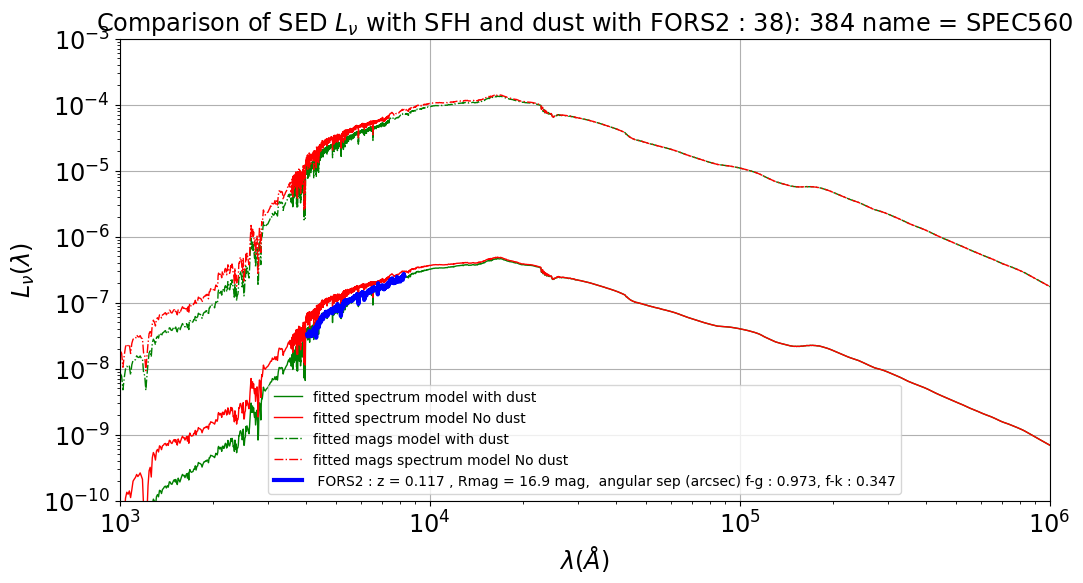

In [127]:
fig, ax = plt.subplots(1, 1)
__=ax.loglog()
__=ax.set_xlim(1e3,1e6)
__=ax.set_ylim(1e-10,1e-3)
ax.set_xlabel("$\lambda (\\AA)$")
ax.set_ylabel("$L_\\nu(\lambda)$")

ax.plot(ssp_data.ssp_wave,Y_fit_s,'-',color='green',lw=1,label="fitted spectrum model with dust")
ax.plot(ssp_data.ssp_wave,Y_fit_nodust_s,'-',color='red',lw=1,label="fitted spectrum model No dust")

ax.plot(ssp_data.ssp_wave,Y_fit_m,'-.',color='green',lw=1,label="fitted mags model with dust")
ax.plot(ssp_data.ssp_wave,Y_fit_nodust_m,'-.',color='red',lw=1,label="fitted mags spectrum model No dust")

ax.plot(Xspec_data,Yspec_data,'b-',lw=3,label=the_label_data)


title = "Comparison of SED $L_\\nu$ with SFH and dust with " + title_data
ax.set_title(title)
ax.legend()
ax.grid()

### $L_\lambda$

In [128]:
YL_fit_s = Y_fit_s*3e18/(ssp_data.ssp_wave)**2
YL_fit_nodust_s = Y_fit_nodust_s*3e18/(ssp_data.ssp_wave)**2

YL_fit_m = Y_fit_m*3e18/(ssp_data.ssp_wave)**2
YL_fit_nodust_m = Y_fit_nodust_m*3e18/(ssp_data.ssp_wave)**2

YL = Yspec_data*3e18/Xspec_data**2

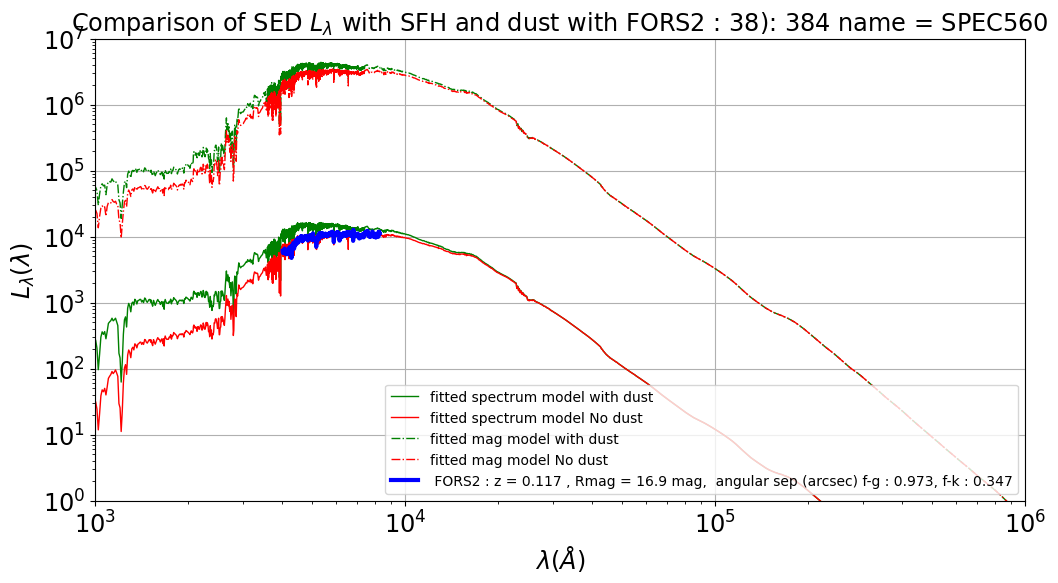

In [137]:
fig, ax = plt.subplots(1, 1)
__=ax.loglog()
__=ax.set_xlim(1e3,1e6)
__=ax.set_ylim(1e0,1e7)
ax.set_xlabel("$\lambda (\\AA)$")
ax.set_ylabel("$L_\lambda(\lambda)$")

ax.plot(ssp_data.ssp_wave,YL_fit_nodust_s,'-',color='green',lw=1,label="fitted spectrum model with dust")
ax.plot(ssp_data.ssp_wave,YL_fit_s,'-',color='red',lw=1,label="fitted spectrum model No dust")

ax.plot(ssp_data.ssp_wave,YL_fit_nodust_m,'-.',color='green',lw=1,label="fitted mag model with dust")
ax.plot(ssp_data.ssp_wave,YL_fit_m,'-.',color='red',lw=1,label="fitted mag model No dust")


ax.plot(Xspec_data,YL,'b-',lw=3,label=the_label_data)


title = "Comparison of SED $L_\\lambda$ with SFH and dust with " + title_data
ax.set_title(title)
ax.legend(loc="lower right")
ax.grid()

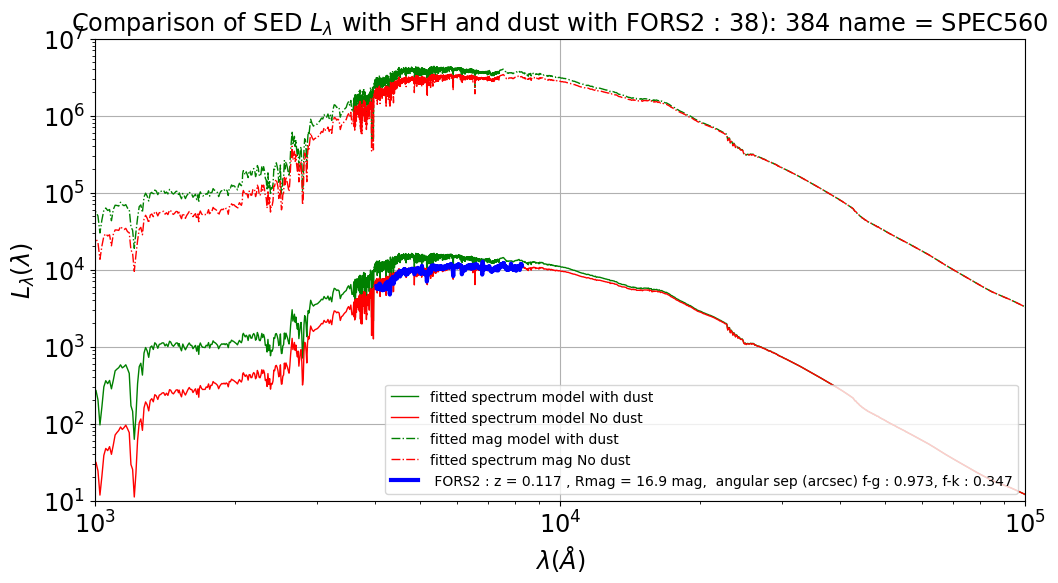

In [136]:
fig, ax = plt.subplots(1, 1)
__=ax.loglog()
__=ax.set_xlim(1e3,1e5)
__=ax.set_ylim(1e1,1e7)
ax.set_xlabel("$\lambda (\\AA)$")
ax.set_ylabel("$L_\lambda(\lambda)$")

ax.plot(ssp_data.ssp_wave,YL_fit_nodust_s,'-',color='green',lw=1,label="fitted spectrum model with dust")
ax.plot(ssp_data.ssp_wave,YL_fit_s,'-',color='red',lw=1,label="fitted spectrum model No dust")
ax.plot(ssp_data.ssp_wave,YL_fit_nodust_m,'-.',color='green',lw=1,label="fitted mag model with dust")
ax.plot(ssp_data.ssp_wave,YL_fit_m,'-.',color='red',lw=1,label="fitted spectrum mag No dust")

ax.plot(Xspec_data,YL,'b-',lw=3,label=the_label_data)

title = "Comparison of SED $L_\\lambda$ with SFH and dust with " + title_data
ax.set_title(title)
ax.legend(loc="lower right")
ax.grid()

### Check the SFH


In [138]:
tarr_fit_s,sfr_fit_s = mean_sfr(dict_params_fitted_s)
tarr_fit_m,sfr_fit_m = mean_sfr(dict_params_fitted_m)

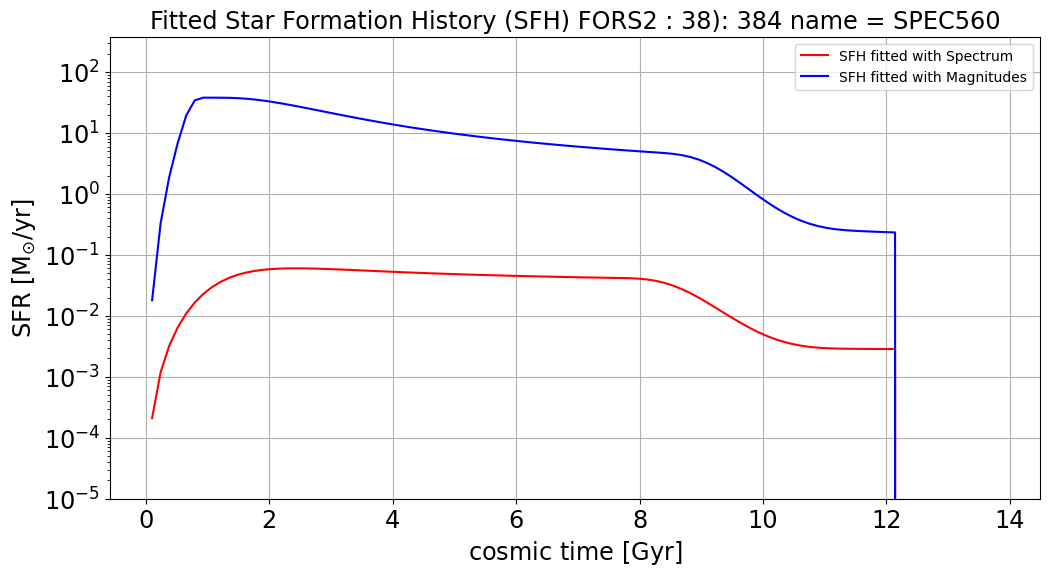

In [141]:
sfr_max_s = sfr_fit_s.max()*10.
sfr_min_s = sfr_max_s/1e4

sfr_max_m = sfr_fit_m.max()*10.
sfr_min_m = sfr_max_m/1e4

sfr_max = max(sfr_max_s,sfr_max_m)
fig, ax = plt.subplots(1, 1)


ylim = ax.set_ylim(1e-5, sfr_max)
yscale = ax.set_yscale('log')

__=ax.plot(tarr_fit_s, sfr_fit_s, '-', color='r',label='SFH fitted with Spectrum')
__=ax.plot(tarr_fit_m, sfr_fit_m, '-', color='b',label='SFH fitted with Magnitudes')

ax.set_title("Fitted Star Formation History (SFH) " + title_data)
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'${\rm SFR\ [M_{\odot}/yr]}$')
ax.grid()
ax.legend()

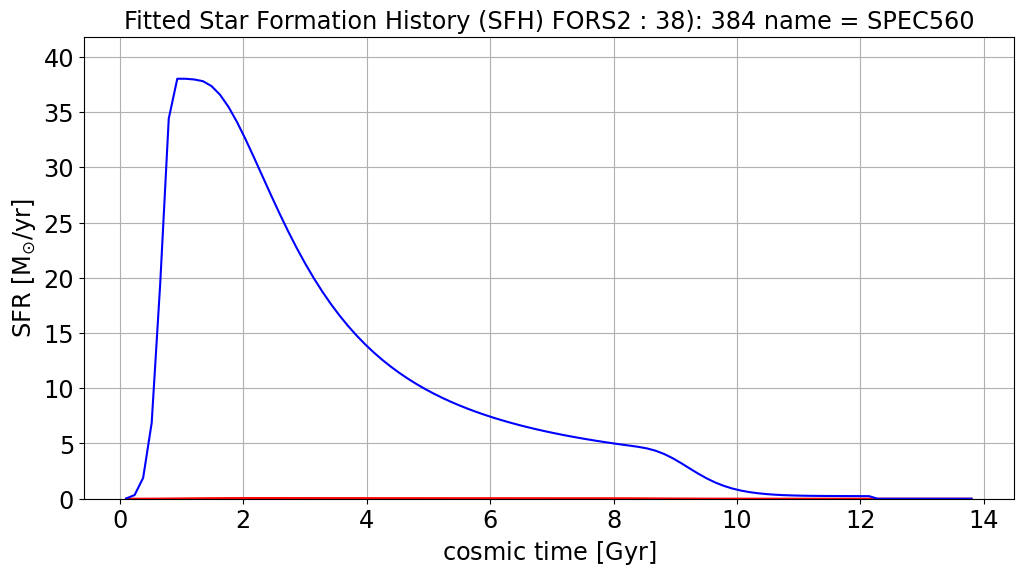

In [145]:
sfr_max_s = sfr_fit_s.max()*1.1
sfr_min_s = sfr_max_s/1e4

sfr_max_m = sfr_fit_m.max()*1.1
sfr_min_m = sfr_max_m/1e4

sfr_max = max(sfr_max_s,sfr_max_m)

fig, ax = plt.subplots(1, 1)
ylim = ax.set_ylim(0, sfr_max)
#yscale = ax.set_yscale('log')

__=ax.plot(tarr_fit_s, sfr_fit_s, '-', color='r',label='SFH fitted with Spectrum')
__=ax.plot(tarr_fit_m, sfr_fit_m, '-', color='b',label='SFH fitted with Magnitudes')
ax.set_title("Fitted Star Formation History (SFH) " + title_data)
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'${\rm SFR\ [M_{\odot}/yr]}$')
ax.grid()